## 프로젝트: 한국어 데이터로 챗봇 만들기
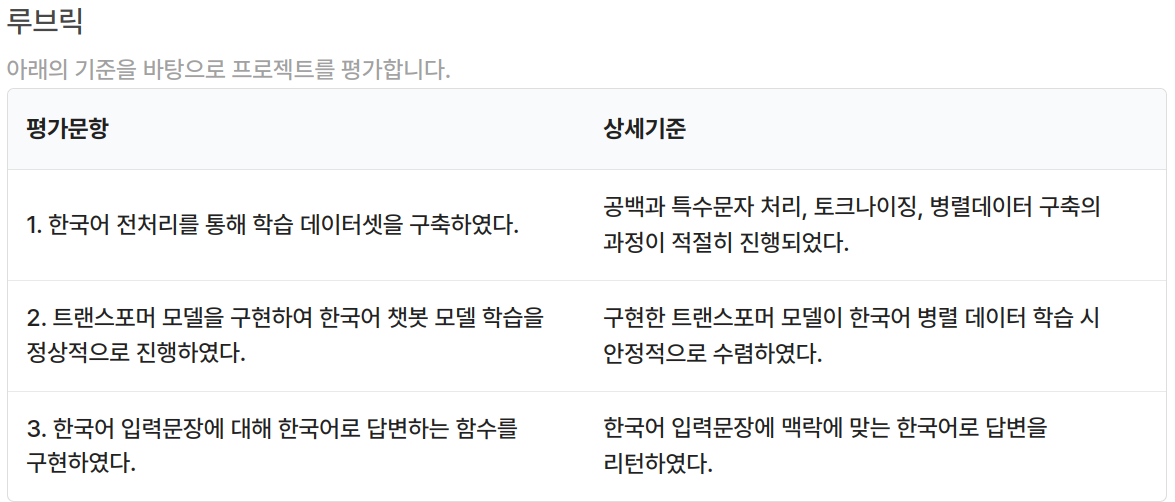

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print(tf.__version__)

2.6.0


### Step 1. 데이터 수집하기

In [2]:
path_to_conversations = os.getenv("HOME")+"/aiffel/transformer_chatbot/data/ChatbotData .csv"

In [3]:
df = pd.read_csv("~/aiffel/transformer_chatbot/data/ChatbotData .csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11823 entries, 0 to 11822
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q       11823 non-null  object
 1   A       11823 non-null  object
 2   label   11823 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 277.2+ KB


In [5]:
df.sample(10)

,Q,A,label
4264,중국어 혼자 공부 가능한가?,혼자해도 좋고 학원을 다녀도 좋아요.,0
9142,나 왜 이렇게 화냈었지?,돌아보면 다그치지 않고 화내지 않아도 될 일이었을 거예요.,2
4239,주택 청약 시작!,내 집 마련의 한 걸음을 내딛으셨네요.,0
7737,이젠 그냥 조금만 자극이와도 눈물이.,이별은 상처를 남기고 가니까요.,1
1733,몸매가 탄탄하면 좋은데,운동으로 만들어 보아요.,0
9601,대출껴서 집사는게 맞나?,갚을 능력이 되는지 생각해보세요.,2
11307,지금 여친을 별로 안좋아하는 것 같아.,마음이 식었나봐요.,2
9422,남친이 나를 안 좋아하는 것 같은데 내가 붙잡고 있는 것 같아.,충분한 대화가 필요하겠어요.,2
448,꿈이 다양해,많으면 많을 수록 좋죠.,0
6271,매번 헤어지면서 회의감,뜻하던 대로 되기 쉽지 않으니까요.,1


In [6]:
len(df)

11823

In [7]:
# 사용할 샘플의 최대 개수
MAX_SAMPLES = 11823
print(MAX_SAMPLES)

11823


### Step 2. 데이터 전처리하기

In [8]:
# 전처리 함수
def preprocess_sentence(sentence):
  sentence = sentence.lower().strip()

  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  # 예를 들어서 "I am a student." => "I am a student ."와 같이
  # student와 온점 사이에 거리를 만듭니다.
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)

  # 한글, 숫자 
  sentence = re.sub(r"[^가-힣0-9?.!,]+", " ", sentence)
  sentence = sentence.strip()
  return sentence

In [9]:
# 질문과 답변의 쌍인 데이터셋을 구성하기 위한 데이터 로드 함수(새로 짜야한다)
def load_conversations():
    inputs, outputs = [], []
    with open(path_to_conversations, 'r') as file:
        lines = file.readlines()
        
    conversation = []
    for line in lines[1:]:
        parts = line.split(',')
        conversation.append([line for line in parts[0:2]])

        
    for i in range(len(conversation) - 1):
        # 전처리 함수를 질문에 해당되는 inputs와 답변에 해당되는 outputs에 적용.
        inputs.append(preprocess_sentence(conversation[i][0]))
        outputs.append(preprocess_sentence(conversation[i][1]))

    if len(inputs) >= MAX_SAMPLES:
        return inputs, outputs

    return inputs, outputs

In [10]:
# 데이터를 로드하고 전처리하여 질문을 questions, 답변을 answers에 저장
questions, answers = load_conversations()
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11822
전체 샘플 수 : 11822


IndexError: list index out of range 에러가 나왔다.    
노드의 load_conversations()함수 코드를 그대로 가져와서 에러가 난 것이었다.    
데이터의 종류가 다르므로 새로 짜면 해결된다. 

In [11]:
print('전처리 후의 999번째 질문 샘플: {}'.format(questions[998]))
print('전처리 후의 999번째 답변 샘플: {}'.format(answers[998]))

전처리 후의 999번째 질문 샘플: 노래방 가고 싶어
전처리 후의 999번째 답변 샘플: 즐거운 시간이 될 거 같아요


### Step 3. SubwordTextEncoder 사용하기

In [12]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

In [13]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8132]
END_TOKEN의 번호 : [8133]


In [14]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8134


In [15]:
# 임의의 999번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 999번째 질문 샘플: {}'.format(tokenizer.encode(questions[998])))
print('정수 인코딩 후의 999번째 답변 샘플: {}'.format(tokenizer.encode(answers[998])))

정수 인코딩 후의 999번째 질문 샘플: [2111, 211, 25]
정수 인코딩 후의 999번째 답변 샘플: [815, 71, 82, 8, 22]


In [16]:
questions_len = [len(s.split()) for s in questions]
answers_len = [len(s.split()) for s in answers]
print(f'questions 최대 길이 : {np.max(questions_len)}')
print(f'questions 평균 길이 : {np.mean(questions_len)}')
print(f'answers 최대 길이 : {np.max(answers_len)}')
print(f'answers 평균 길이 : {np.mean(answers_len)}')

questions 최대 길이 : 16
questions 평균 길이 : 3.925393334461174
answers 최대 길이 : 24
answers 평균 길이 : 4.68423278633057


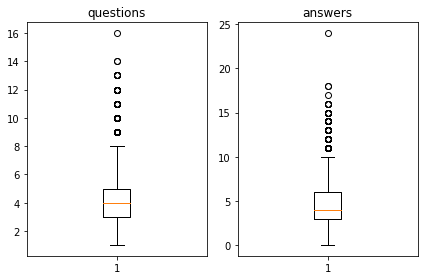

In [17]:
plt.subplot(1,2,1)
plt.boxplot(questions_len)
plt.title('questions')
plt.subplot(1,2,2)
plt.boxplot(answers_len)
plt.title('answers')
plt.tight_layout()
plt.show()

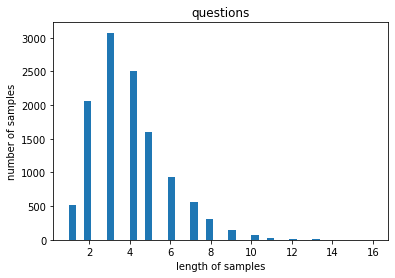

In [18]:
# questions 길이 분포 
plt.title('questions')
plt.hist(questions_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

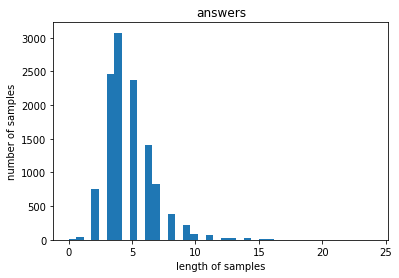

In [19]:
# answers 길이 분포 
plt.title('answers')
plt.hist(answers_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

questions, answers 각각의 최대 길이는 16, 24자다.    
최대 허용 길이는 11자로 설정했다. 

In [20]:
# 최대 허용 길이 지정
MAX_LENGTH = 11

In [21]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # MAX_LENGTH 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # MAX_LENGTH로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs

In [22]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8134
필터링 후의 질문 샘플 개수: 10168
필터링 후의 답변 샘플 개수: 10168


In [23]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용.
# outputs에서 START_TOKEN 제거
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

### Step 4. 모델 구성하기

In [24]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [25]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

In [26]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs

In [27]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [28]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

In [29]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [30]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [31]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [32]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [33]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [34]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.5 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3136512     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [35]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

In [36]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

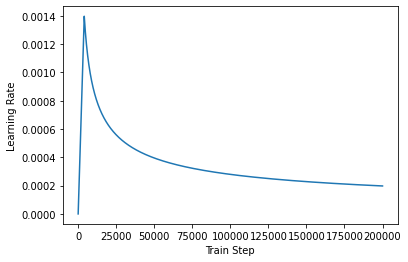

In [37]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [38]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [39]:
EPOCHS = 200
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/200
159/159 [==============================] - 11s 29ms/step - loss: 5.3192 - accuracy: 0.0656
Epoch 2/200
159/159 [==============================] - 4s 28ms/step - loss: 4.4942 - accuracy: 0.1007
Epoch 3/200
159/159 [==============================] - 4s 28ms/step - loss: 3.7350 - accuracy: 0.1838
Epoch 4/200
159/159 [==============================] - 5s 29ms/step - loss: 3.4902 - accuracy: 0.1931
Epoch 5/200
159/159 [==============================] - 5s 29ms/step - loss: 3.3559 - accuracy: 0.1947
Epoch 6/200
159/159 [==============================] - 5s 29ms/step - loss: 3.2341 - accuracy: 0.1976
Epoch 7/200
159/159 [==============================] - 5s 29ms/step - loss: 3.1453 - accuracy: 0.2028
Epoch 8/200
159/159 [==============================] - 4s 28ms/step - loss: 3.0603 - accuracy: 0.2090
Epoch 9/200
159/159 [==============================] - 5s 28ms/step - loss: 2.9721 - accuracy: 0.2137
Epoch 10/200
159/159 [==============================] - 5s 28ms/step - loss: 2.88

ValueError: `validation_split` is only supported for Tensors or NumPy arrays, found following types in the input: [<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>] 에러가 났다.     
validation_split을 빼고, 그에 따라 val_loss가 없어져 EarlyStopping도 빼야했다. 

### Step 5. 모델 평가하기

In [40]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)
print("슝=3")

슝=3


In [41]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence
print("슝=3")

슝=3


In [42]:
question_list = [
    '별거 아니야',
    '요즘은 어떤 책 읽어?',
    '내일 같이 영화볼래?',
    '그래 걔 그럴줄 알았어',
    '처음 뵙겠습니다.',
    '어디 어른 말씀하시는데 말대꾸야?',
    '수고하셨습니다.',
    '나는 김치볶음밥이 땡기는데, 너는?',
    '어머나!',
    '얼래 이 자식 좀 보게',
    '아유 귀여워~',
    '헐..완전 대박',
    '사실 니가 내 첫사랑이다?',
    '완전 이번주는 월화수목금금금이었잖아',
    '잘가'
]

In [43]:
def print_answers(question_list):
    for input_qusetion in question_list:
        sentence_generation(input_qusetion)
        print()

In [44]:
print_answers(question_list)

입력 : 별거 아니야
출력 : 별거 없다가도 전부가 되는게 사랑이에요

입력 : 요즘은 어떤 책 읽어?
출력 : 잘 지내는지 자연스럽게 다가가보세요 .

입력 : 내일 같이 영화볼래?
출력 : 환해 보이는 옷이요 !

입력 : 그래 걔 그럴줄 알았어
출력 : 그게 문제는 아닐 거예요 .

입력 : 처음 뵙겠습니다.
출력 : 당신도 잘 지내고 있길 바랄게요 .

입력 : 어디 어른 말씀하시는데 말대꾸야?
출력 : 그냥 얼굴 보면 설레요 .

입력 : 수고하셨습니다.
출력 : 연락이 안되나봐요 .

입력 : 나는 김치볶음밥이 땡기는데, 너는?
출력 : 전 술을 마시지 못해요 .

입력 : 어머나!
출력 : 놀랐나봐요 .

입력 : 얼래 이 자식 좀 보게
출력 : 다음달에는 조금 줄여보세요 .

입력 : 아유 귀여워~
출력 : 잘 생각해보세요 .

입력 : 헐..완전 대박
출력 : 제자리여도 괜찮아요 .

입력 : 사실 니가 내 첫사랑이다?
출력 : 마음이 복잡하겠어요 .

입력 : 완전 이번주는 월화수목금금금이었잖아
출력 : 깊은 사이였나요 .

입력 : 잘가
출력 : 안녕 .



하이퍼파라미터 바꾸기 전에 accuracy가 0.29였는데, 학습할 때의 accuracy가 두 배 가까이 오르고 나서도 테스트할 때의 성능은 별로 변하지 않았다.  
15개의 문장을 입력했을 때, 맥락을 제대로 파악하고 대답한 출력은 두 문장 정도이다.      
accuracy 자체가 별로 의미 없는 것 같다. 

In [45]:
df.sample(15)

,Q,A,label
2242,빨래했어.,부지런하시네요.,0
9966,사랑하는 사람이랑 헤어져,마음이 많이 아프겠어요.,2
316,그냥 택시 타야지.,조심히 오세요.,0
9585,다니던 회사를 그만두고 1년간 여행을 가자고 해.,큰 용기가 필요하겠네요.,2
2568,수강신청 폭망,정정기간을 노려 보세요.,0
10195,썸 타는 사람 있는데 망설여지는데,어떤 부분이 망설여지는지 말씀해보세요.,2
10486,어떨때 연인이 변했다고 생각해?,연락과 데이트로 바로 느껴지죠.,2
11430,짝남이랑 약속 파토 남.,아쉽네요.,2
9600,대출 엄청 끼고 집 사,갚을 능력이 되는지 생각해보세요.,2
6073,답답하네 . 뒤숭숭하고,아직 받아들여지지 않아서 그런가봐요.,1


이제와서 오리지널 데이터셋 다시 보자면, 마지막에 내가 출력해본 문장보다는 훨씬 낫지만, 일부는 애초에 사람들 간의 일상 대화보다는 조금 부자연스럽다는 느낌이 든다.     
데이터 자체를 챗봇형의 대화가 아닌 일상 회화를 넣었으면, 조금 더 자연스러운 대답이 출력되었을 것 같다.    


## 회고

**헤맨 부분** 
- nlp 부분을 할 때마다 드는 생각이지만, 이미지에 반영되어 코드를 시각적으로 바로 이해할 수 있는 cv와 달리, nlp는 코드 파악부터가 너무 어렵다. 
- 특히 이번 노드는 코드가 드문드문 다오면서 이론이 많았는데, 그 때문에 막상 프로젝트에 돌입했을 때 어디서부터 어떻게 시작해야하는지 막막했다. 
- 모르는 부분이 많아서, 이번 프로젝트는 주체적으로 하지 못하고 노드와 다른 사람들의 코드를 보면서 다시 이해해보는 방향으로 진행했다. 

**새롭게 알게된 부분**
- 문장의 최대 길이가 24자로 많이 길지는 않았기 때문에, 처음에는 MAX_LENGTH를 줄이지 않았다. 그런데 11자로 줄이고 나서 실험해보니 accuracy가 0.29에서 0.52로 약 두 배 정도 증가했다. 완전한 문장이 아니게되더라도, 데이터의 크기를 맞춰주는게 중요한 것 같다. 
- model.fit()에서 validation_split은 Tensor, NumPy 유형일 때만 적용할 수 있다. Dataframe 형태라 적용이 안됐다. validation을 없애니 validation loss가 없어서 early stopping도 넣을 수 없다.   

**아직도 모르는 부분**
- 각 함수들을 정의하는 노드의 코드를 아직도 이해하지 못했다. 
- 하이퍼파라미터 바꾸면서 accuracy는 0.29에서 0.52로 증가했지만 테스트의 대답 성능은 차이를 느낄 수 없었다. 하이퍼파라미터로 이 이상 성능을 개선할 수 없는걸까? 데이터나 모델 자체를 변형한다면 조금 더 나아질까?